In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import astropy.coordinates as coord
from matplotlib import rcParams

rcParams['font.size'] = 16
rcParams['font.family'] = 'serif'
rcParams['text.usetex'] = True

In [2]:
SNlist = pd.read_csv("../data/optnir-transients/ASASSN/sn_list.csv")

In [3]:
dL_arr = np.array([])
for z in SNlist.Redshift:
    if z == "Unk":
        dL = -99.
    else:
        dL = cosmo.luminosity_distance(float(z))/u.Mpc
    dL_arr = np.append(dL_arr, dL)

In [4]:
SNlist['dL'] = dL_arr

In [5]:
cmap = colors.LinearSegmentedColormap.from_list('',['w','C0'],256)

In [6]:
dstep = 5
ra_bins = np.arange(-180,181,dstep)
dec_bins = np.arange(-90,91,dstep)

In [7]:
RAs = np.array([])
for RA in (SNlist.RA).values:
    RAs = np.append(RAs,float(RA))
    
Decs = np.array([])
for Dec in (SNlist.Dec).values:
    Decs = np.append(Decs,float(Dec))

In [8]:
ra = coord.Angle(RAs*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(Decs*u.degree)

In [9]:
ra_assns = np.digitize(ra.to(u.deg), ra_bins)
dec_assns = np.digitize(dec.to(u.deg), dec_bins)

In [10]:
# \\ Build reverse engineered footprint
fgrid = np.zeros([ra_bins.size,dec_bins.size])

for ra_id, dec_id in zip(ra_assns,dec_assns):
    fgrid[ra_id-1,dec_id-1] = 1

In [11]:
np.save('./ASASSN_footprint.npy', fgrid)

In [12]:
RAg,DECg = np.meshgrid(np.deg2rad(ra_bins),np.deg2rad(dec_bins))

In [13]:
rstep = np.deg2rad(dstep)

# \\ build dA grid 
agrid = np.zeros_like(fgrid)
for i in range(fgrid.shape[0]):
    for j in range(fgrid.shape[1]):
        dA = abs(rstep * (np.sin(DECg[j,i]+rstep) - np.sin(DECg[j,i])))
        agrid[i,j] = dA

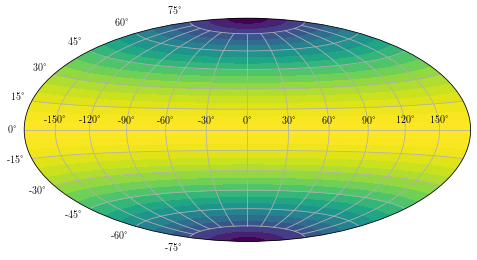

In [14]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="hammer")
ax.pcolormesh ( RAg,DECg, agrid.T, cmap='viridis')
ax.grid ()

Text(0, 0.5, 'Dec (deg)')

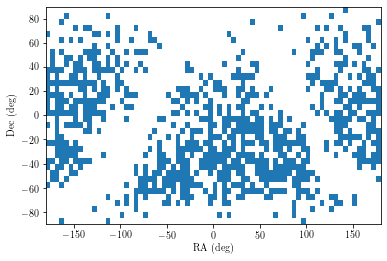

In [15]:
ax = plt.subplot(111)
ax.pcolor(ra_bins,dec_bins,fgrid.T, cmap=cmap)
#plt.scatter(ra, dec, s=1)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')

/Users/ghalevi/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:341: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1 - (x / 4) ** 2 - (y / 2) ** 2)


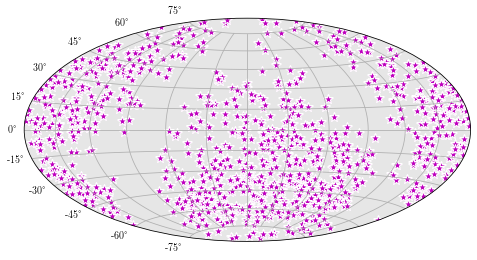

In [16]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="hammer")
ax.scatter(ra.radian, dec.radian, marker='*', s = 100,color='m',edgecolor='w')
ax.set_facecolor('0.9')
ax.set_xticklabels('')

ax.grid()

In [17]:
dLs = dL_arr.value
dLs_sub = np.array([])
ras_sub = np.array([])
decs_sub = np.array([])
ras_noz = np.array([])
decs_noz = np.array([])
for dL, r, d in zip(dLs, ra.radian, dec.radian):
    if dL != -99:
        dLs_sub = np.append(dLs_sub,dL)
        ras_sub = np.append(ras_sub,r)
        decs_sub = np.append(decs_sub,d)
    else:
        ras_noz = np.append(ras_noz, r)
        decs_noz = np.append(decs_noz, d)
print(dLs_sub.min())
print(np.median(dLs_sub))
print(dLs_sub.max())

10.507495242520259
127.88384831074113
1175.332888282045


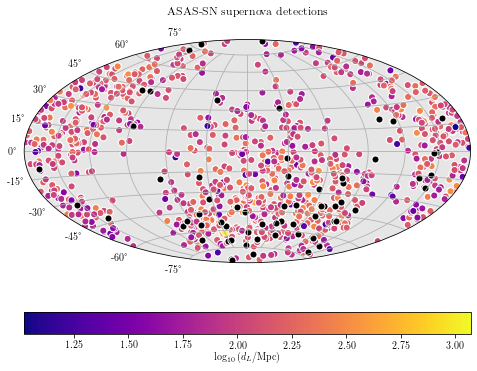

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="hammer")
sc = ax.scatter(ras_sub, decs_sub, marker='o', s = 50,c=np.log10(dLs_sub),cmap='plasma',edgecolor='w')
ax.scatter(ras_noz, decs_noz, marker = 'o', s = 50, color='k',edgecolor='w')
ax.set_facecolor('0.9')
ax.set_xticklabels('')
cb = plt.colorbar(sc,orientation='horizontal',label=r'$\log_{10}{(d_L/\mathrm{Mpc})}$')

ax.set_title('ASAS-SN supernova detections',pad=25)

ax.grid()

plt.savefig('ASASSN_2d.png',dpi=300)

In [19]:
xs = np.cos(ras_sub) * np.cos(decs_sub) * dLs_sub
ys = np.sin(ras_sub) * np.cos(decs_sub) * dLs_sub
zs = np.sin(decs_sub) * dLs_sub

In [20]:
#COMA: 12 59 48.7 +27 58 50 | d=99 Mpc
#NORMA: 16 14 22.5 -60 52 07 | d=68 Mpc
#PERSEUS-PISCES | 01h 50m +36° 00′ | 77 Mpc
clusters = ['Coma', 'Great Attractor','Perseus-Pisces','Virgo','Hercules','Shapley','Pavo-Indus']
clusters_cs = ["12h59m48s +27d58m50s", "16h14m22s -60d52m7s", "01h50m0s +36d00m00s", "12h26m32.1s 12d43m24s",
              "15h47m00.0s +18d12m00s", "13h25m −30d", "20h48m26s −39d06m09s"]
clusters_ds = [99.,68.,77.,16.5,100.,200.,65.]
clusters_xs = []
clusters_ys = []
clusters_zs =[]
for i in np.arange(len(clusters)):
    c = coord.SkyCoord(clusters_cs[i], frame='icrs')
    x = np.cos(c.ra.rad) * np.cos(c.dec.rad) * clusters_ds[i]
    y = np.sin(c.ra.rad) * np.cos(c.dec.rad) * clusters_ds[i]
    z = np.sin(c.dec.rad) * clusters_ds[i]
    clusters_xs.append(x)
    clusters_ys.append(y)
    clusters_zs.append(z)

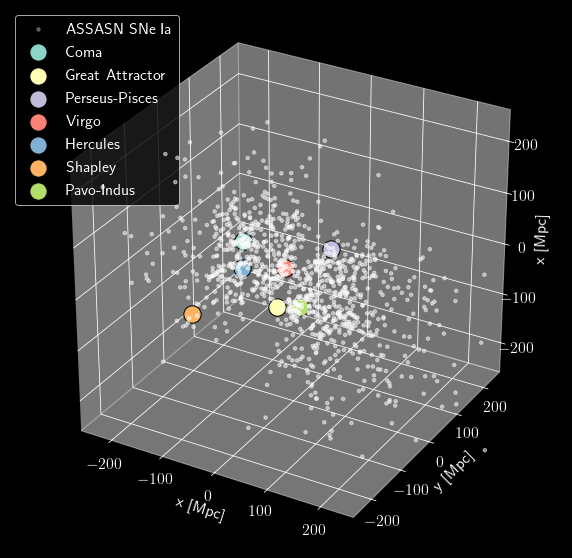

In [40]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
plt.style.use('dark_background')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, s=12,facecolor='w',label='ASSASN SNe Ia',alpha=0.3)
for i in np.arange(len(clusters)):
    ax.scatter(clusters_xs[i], clusters_ys[i] , clusters_zs[i],s=300,edgecolor='k',label=clusters[i])
ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)
ax.set_zlim(-250, 250)
ax.set_xlabel("x [Mpc]")
ax.set_ylabel("y [Mpc]")
ax.set_zlabel("x [Mpc]")
ax.grid(True)
plt.axis('on')
plt.legend(fancybox='True',frameon='True',loc=2)
plt.savefig('ASASSN_3d.png',dpi=200)

In [22]:
clusters_xs[0], clusters_ys[0], clusters_zs[0]

(-84.4682716605665, -22.554218836684363, 46.44801713037588)